In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf

# <font face="gotham" color="purple"> Dynamic Econometric Models </font>

After discussions of autocorrelation, we are officially entering the realm of time series econometrics. For starter, we will discuss dynamic econometric models: **distributed-lag model** and **autogressive model**. 

In economics and finance, dependent variables and explanatory (independent) variables are rarely instantaneous, i.e. $Y$ responds to $X$'s with a lapse of time.

## <font face="gotham" color="purple"> Distributed-Lag Model (DLM) </font>

Here is a DLM with one explanatory variable $X$
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{1} X_{t-1}+\beta_{2} X_{t-2}+\cdots+u_{t}
$$

### <font face="gotham" color="purple"> Ad Hoc Estimation Of DLM </font>

If you are estimating variables which have no clear economic relationship or no well-founded theoretical support, go with ad hoc estimation method. 

So you start regressing $X_t$ onto $Y_t$, then adding $X_{t-i}$ where $i \geq 1$ in each round of regression, until $t$-statistic starting to be insignificant or signs of coefficients start to be unstable.

\begin{align}
\hat{Y}_t &= a + b_0X_t\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_2X_{t-2}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_1X_{t-1}+b_3X_{t-3}\\
\end{align}

But be aware that ad hoc method is bring significant problem of multicollinearity. 

### <font face="gotham" color="purple"> Koyck Approach To DLM </font>

Koyck approach assumes that all $\beta$'s are of the same sign, furthermore
$$
\beta_{k}=\beta_{0} \lambda^{k} \quad k=0,1, \ldots
$$
where $\lambda$ is the _rate of decay_, $0<\lambda<1$.

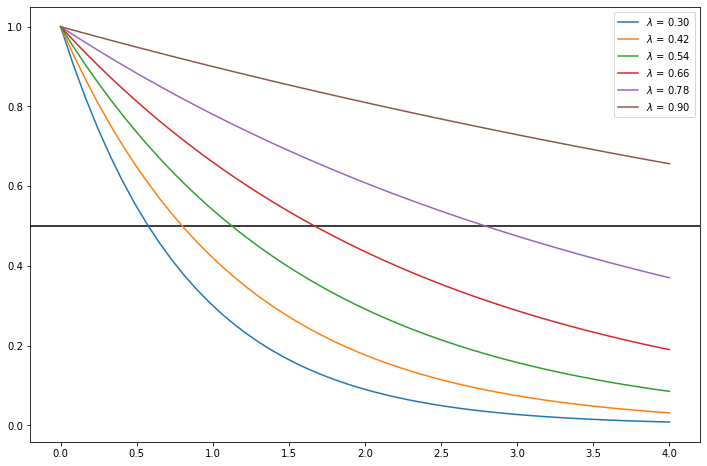

In [41]:
lamda = np.linspace(0.3, .9, 6)
beta_0 = 1
k = np.linspace(0, 4)
fig, ax = plt.subplots(figsize = (12, 8))
for i in lamda:
    beta_k = beta_0*i**k
    ax.plot(k, beta_k, label = '$\lambda$ = %.2f'%i)
ax.legend()
ax.axhline(y = 0.5, zorder = -10, color = 'k')
plt.show()

There are three perks of Koyck approach:

1. By assuming nonnegative values for $λ$, $\beta$'s sign are stable; 
2. by assuming $λ < 1$, lesser weight is given to the distant $β$'s than the current ones; 
3. The sum of the $β$'s, which gives the long-run multiplier, is finite, i.e.
$$
\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)
$$

Naturally, the infinite distributed lag  model can be rewritten as
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{0} \lambda X_{t-1}+\beta_{0} \lambda^{2} X_{t-2}+\cdots+u_{t}
$$

Lag both sides one period
$$
Y_{t-1}=\alpha+\beta_{0} X_{t-1}+\beta_{0} \lambda X_{t-2}+\beta_{0} \lambda^{2} X_{t-3}+\cdots+u_{t-1}
$$

Multiply by $\lambda$
$$
\lambda Y_{t-1}=\lambda \alpha+\lambda \beta_{0} X_{t-1}+\beta_{0} \lambda^{2} X_{t-2}+\beta_{0} \lambda^{3} X_{t-3}+\cdots+\lambda u_{t-1}
$$
Join with original equation
$$
Y_{t}-\lambda Y_{t-1}=\alpha(1-\lambda)+\beta_{0} X_{t}+\left(u_{t}-\lambda u_{t-1}\right)
$$

Rearrange, we obtain
$$
Y_{t}=\alpha(1-\lambda)+\beta_{0} X_{t}+\lambda Y_{t-1}+v_{t}
$$
where $v_t = (u_t − λu_{t−1})$.

This is called **Koyck transformation** which simplifies original infinite DLM into an $AR(1)$.

### <font face="gotham" color="purple"> An Example Of Consumption And Income </font>

We import macro data from FRED, $PCE$ is _real personal consumption expenditure_ and $DI$ is _real disposable income per capita_. 

In [104]:
start = dt.datetime(2002, 1, 1)
end = dt.datetime(2021,8, 1)
df_exp = pdr.data.DataReader(['PCEC96','A229RX0'], 'fred' , start, end)
df_exp.columns = ['PCE', 'DI']
df_exp = df_exp.dropna()
df_exp.head()

,PCE,DI
DATE,,
2002-01-01,9004.4,34707.0
2002-02-01,9040.1,34735.0
2002-03-01,9038.2,34734.0
2002-04-01,9086.5,34827.0
2002-05-01,9051.4,34941.0


Define a function for lagging, which is handy in $R$-style formula.

In [101]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 
    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

The model is 
$$
PCE_t = \alpha(1-\lambda) + \beta_0 DI_t + \lambda PCE_{t-1}+ v_t
$$

In [102]:
DLM = smf.ols(formula = 'PCE ~ 1 + lag(DI, 0) + lag(PCE, 1)', data = df_exp)
DLM_results = DLM.fit()
print(DLM_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1493.
Date:                Wed, 27 Oct 2021   Prob (F-statistic):           2.82e-93
Time:                        16:53:29   Log-Likelihood:                -923.43
No. Observations:                 139   AIC:                             1853.
Df Residuals:                     136   BIC:                             1862.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     119.3800    219.954      0.543      

The estimated results:

In [85]:
beta_0 = DLM_results.params[1]
lamda = DLM_results.params[2]
alpha = DLM_results.params[0]/(1-DLM_results.params[2])

print('beta_0 = {}'.format(beta_0))
print('lambda = {}'.format(lamda))
print('alpha = {}'.format(alpha))

beta_0 = 0.02292255662377629
lambda = 0.9294829077279697
alpha = -1547.59673970508


Any $\beta_k$ is given by $\beta_{k}=\beta_{0} \lambda^{k}$

In [86]:
def beta_k(lamda, k, beta_0):
    return beta_0 * lamda**k

In [87]:
beta_k(lamda, 1, beta_0)

0.02130612458322662

The long run multiplier given by $\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)$

In [89]:
beta_0*(1/(1-lamda))

0.32506383750692786

In [90]:
1/(1-lamda)

14.180959080705563